In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import wfdb  # For å lese .dat og .hea filer

## Load the data
This dataset is very large, will take several hours to download.

In [ ]:
!curl -O https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip

In [ ]:
!unzip -q ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip
!ls

## Preprocessing

Length of ECG signal: 5000 samples
Duration of ECG signal: 10.0 seconds


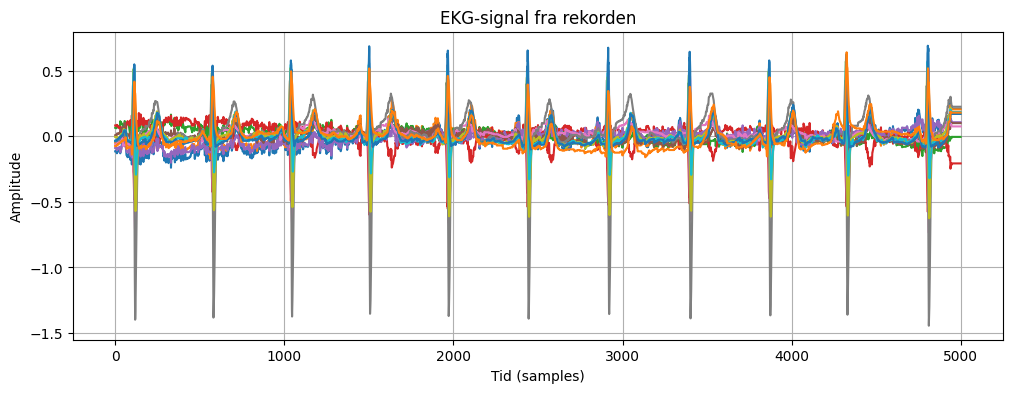

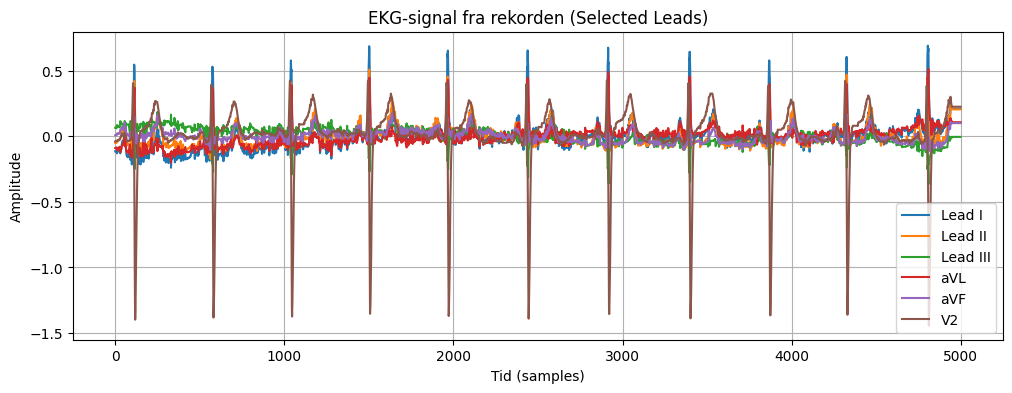

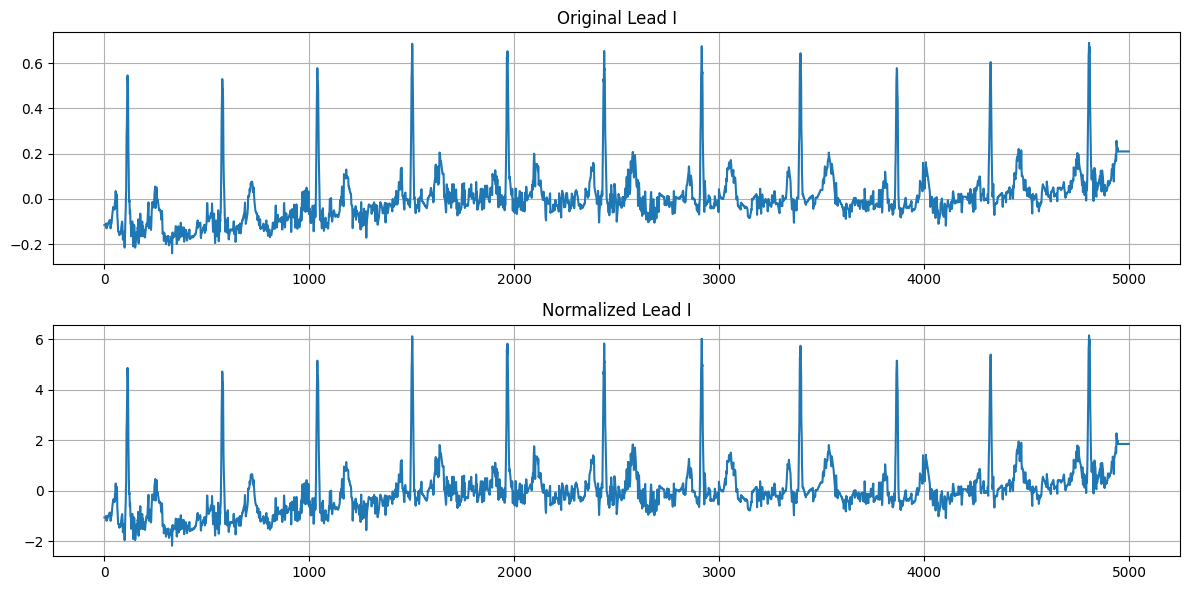

Distribution of diagnostic classes:
NORM: 9438 samples (43.30%)
MI: 4134 samples (18.96%)
STTC: 5078 samples (23.29%)
CD: 4891 samples (22.44%)
HYP: 2258 samples (10.36%)


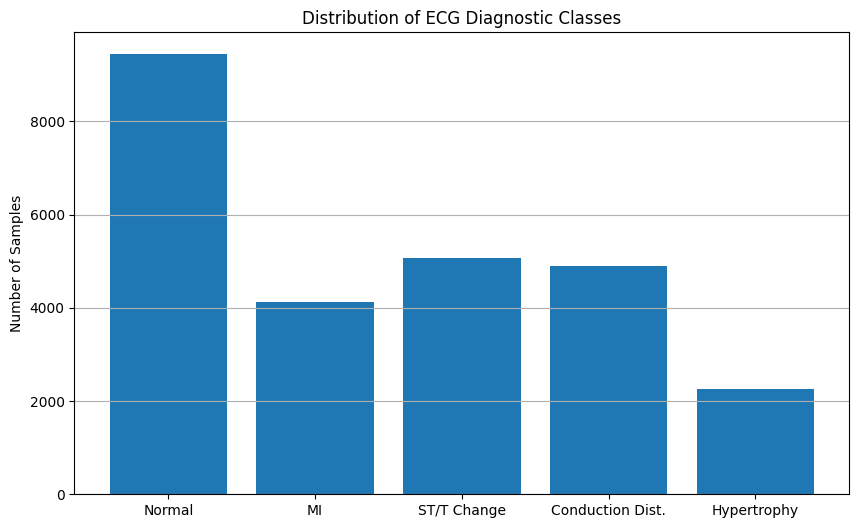

Number of multi-label records: 4390 (20.14%)
Shape of X: (21799, 5000, 12)
Shape of y: (21799, 5)


In [ ]:
# Load dataset
DATASET_DIR = "/Users/daniel1/Desktop/Skole/SemesterV2025/DAT255/DAT255Prosjekt/1D-CNN_For_ECG_measurements/notebooks/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"

# Load metadata
df = pd.read_csv(os.path.join(DATASET_DIR, "ptbxl_database.csv"))
df_labels = pd.read_csv(os.path.join(DATASET_DIR, "scp_statements.csv"))

df.head()

# Visualize an ECG with all 12 leads
# Select a random ECG record
record_name = df.loc[0, "filename_hr"]  # Get file path

# Function to load ECG signal
def load_ecg(record_name):
    """Loads ECG signal from PTB-XL .dat files."""
    file_path = os.path.join(DATASET_DIR, record_name)
    record = wfdb.rdsamp(file_path)  # Load ECG recording
    return record[0]  # Extract raw ECG signal

# Load ECG signal
ecg_signal = load_ecg(record_name)

# Check the length of the ECG signal
print(f"Length of ECG signal: {len(ecg_signal)} samples")

# Assuming the sampling rate is 500 Hz (common for ECG data), 10 seconds would be 5000 samples
sampling_rate = 500
duration = len(ecg_signal) / sampling_rate
print(f"Duration of ECG signal: {duration} seconds")

# Select Relevant ECG Leads (Lead I, Lead II, Lead III, Lead aVL, Lead aVF, Lead V2)
FOCUS_LEADS = [0, 1, 2, 4, 5, 7]  # Lead I, Lead II, Lead III, aVL, aVF, V2
FOCUS_LEAD_NAMES = ["Lead I", "Lead II", "Lead III", "aVL", "aVF", "V2"]

# Visualize the six selected leads
ecg_subset = ecg_signal[:, FOCUS_LEADS]

# Plot the entire 10-second ECG signal
plt.figure(figsize=(12, 4))
plt.plot(ecg_signal)
plt.title('EKG-signal fra rekorden')
plt.xlabel('Tid (samples)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Plot the six selected leads
plt.figure(figsize=(12, 4))
for i in range(ecg_subset.shape[1]):
    plt.plot(ecg_subset[:, i], label=FOCUS_LEAD_NAMES[i])
plt.title('EKG-signal fra rekorden (Selected Leads)')
plt.xlabel('Tid (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


# Normalize ECG Signals
def normalize_ecg(ecg_data):
    """
    Normalize ECG data using z-score normalization (zero mean, unit variance)
    Applied to each lead/channel separately
    """
    # Create a copy to avoid modifying the original
    normalized = np.zeros_like(ecg_data, dtype=np.float32)
    
    # Normalize each lead/channel independently
    for i in range(ecg_data.shape[1]):
        mean = np.mean(ecg_data[:, i])
        std = np.std(ecg_data[:, i])
        # Avoid division by zero
        if std == 0:
            normalized[:, i] = ecg_data[:, i] - mean
        else:
            normalized[:, i] = (ecg_data[:, i] - mean) / std
            
    return normalized

# Visualize difference between original and normalized ECG
# Normalize the subset with our 6 focus leads
normalized_ecg = normalize_ecg(ecg_subset)

# Plot original vs normalized for first lead (Lead I)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(ecg_subset[:, 0])
plt.title(f'Original {FOCUS_LEAD_NAMES[0]}')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(normalized_ecg[:, 0])
plt.title(f'Normalized {FOCUS_LEAD_NAMES[0]}')
plt.grid()
plt.tight_layout()
plt.show()

# Zero-padding (signals < 10s) and truncating (signals > 10s) ECG signals
def preprocess_ecg(ecg_data, target_length=5000):
    """
    Ensure all ECG signals have the same length through zero-padding or truncation
    Assumes ECG data has shape (time_steps, n_leads)
    """
    current_length = ecg_data.shape[0]
    
    if current_length > target_length:
        # Truncate to target length
        return ecg_data[:target_length, :]
    elif current_length < target_length:
        # Zero-pad to reach target length
        padded = np.zeros((target_length, ecg_data.shape[1]), dtype=ecg_data.dtype)
        padded[:current_length, :] = ecg_data
        return padded
    else:
        # Already the correct length
        return ecg_data

# Multi-label disease annotations
def process_labels(df, df_labels):
    """
    Process multi-label disease annotations from the PTB-XL dataset
    
    Parameters:
    -----------
    df: DataFrame with PTB-XL metadata
    df_labels: DataFrame with SCP statement codes
    
    Returns:
    --------
    DataFrame with processed multi-label annotations
    """
    # Diagnostic categories in PTB-XL
    diagnostic_superclasses = [
        'NORM',     # Normal ECG
        'MI',       # Myocardial Infarction
        'STTC',     # ST/T Change
        'CD',       # Conduction Disturbance
        'HYP'       # Hypertrophy
    ]

    # Extract diagnostic class information from the scp_codes column
    df['scp_codes'] = df['scp_codes'].apply(lambda x: eval(x))
    
    # Create columns for each diagnostic class
    for diagnostic_class in diagnostic_superclasses:
        df[diagnostic_class] = 0
    
    # Iterate through each record
    for idx, row in df.iterrows():
        scp_codes = row['scp_codes']
        
        # Identify diagnostic classes for each record
        for code, value in scp_codes.items():
            # Get diagnostic class for this code
            code_diag_class = df_labels.loc[df_labels['Unnamed: 0'] == code, 'diagnostic_class'].values
            
            # If code belongs to a diagnostic class and has high confidence (value >= 50%)
            if len(code_diag_class) > 0 and value >= 50 and code_diag_class[0] in diagnostic_superclasses:
                # Mark the class as present
                df.loc[idx, code_diag_class[0]] = 1
    
    return df

# Apply processing to create multi-label annotations
df_with_labels = process_labels(df.copy(), df_labels)

# Analyze the distribution of diagnostic classes
print("Distribution of diagnostic classes:")
for diagnostic_class in ['NORM', 'MI', 'STTC', 'CD', 'HYP']:
    count = df_with_labels[diagnostic_class].sum()
    percent = 100 * count / len(df_with_labels)
    print(f"{diagnostic_class}: {count} samples ({percent:.2f}%)")

# Visualize label distribution
plt.figure(figsize=(10, 6))
label_counts = [df_with_labels[col].sum() for col in ['NORM', 'MI', 'STTC', 'CD', 'HYP']]
plt.bar(['Normal', 'MI', 'ST/T Change', 'Conduction Dist.', 'Hypertrophy'], label_counts)
plt.title('Distribution of ECG Diagnostic Classes')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.show()

# Count number of multi-label cases
multi_label_count = (df_with_labels[['NORM', 'MI', 'STTC', 'CD', 'HYP']].sum(axis=1) > 1).sum()
print(f"Number of multi-label records: {multi_label_count} ({100*multi_label_count/len(df_with_labels):.2f}%)")

# Function to get labels for a specific ECG record
def get_labels_for_record(record_id, df_labels):
    """Get the diagnostic labels for a specific ECG record"""
    record_data = df_labels.loc[df_labels['ecg_id'] == record_id]
    return record_data[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values[0]

# Convert DataFrame to NumPy arrays for model training
def convert_to_numpy(df, target_columns):
    """
    Convert DataFrame to NumPy arrays for model training.
    
    Parameters:
    -----------
    df: DataFrame with ECG data and labels
    target_columns: List of columns to be used as targets/labels
    
    Returns:
    --------
    X: NumPy array with ECG data
    y: NumPy array with labels
    """
    # Extract ECG data (features)
    X = df['filename_hr'].apply(lambda x: load_ecg(x)).values
    X = np.array([preprocess_ecg(x) for x in X])
    
    # Extract labels
    y = df[target_columns].values
    
    return X, y

# Define target columns (diagnostic classes)
target_columns = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

# Convert to NumPy arrays
X, y = convert_to_numpy(df_with_labels, target_columns)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")



In [9]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

y = y.astype(np.float32)

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.4)

X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (13079, 5000, 12), (13079, 5)
Validation set shape: (4360, 5000, 12), (4360, 5)
Testing set shape: (4360, 5000, 12), (4360, 5)
